# Web Scraping the Data

In this section the data is scraped from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. This is used to create a table that stores the postal code, borough, and neighboors.

In [175]:
import numpy as np
import pandas as pd

import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium

This is grabbing everything from the webpage.

In [47]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
hmtl_data = requests.get(url).text

This is changing everything that was grabbed to be read as html code.

In [48]:
soup = BeautifulSoup(hmtl_data, "html5lib")

This section starts by creating an empty list to store the data and load into the DataFrame t_n. Next the code searches for the a table in the html data code, storing it in table. The for loop will go through each line. The loop will skip if the line has 'Not assigned' as a value. If the line doesn't have that it will change the line to text, remove unneeded characters and store it in the made list. After looping through the whole table the list is stored into a DataFrame. The last line cleans up the names of some of the boroughs stored in the DataFrame.

In [49]:
table_contents=[]
#t_n = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhoods']
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
t_n=pd.DataFrame(table_contents)
t_n['Borough']=t_n['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

This is showing the newly created DataFrame.

In [50]:
t_n

PostalCode  ...                                       Neighborhood
0          M3A  ...                                          Parkwoods
1          M4A  ...                                   Victoria Village
2          M5A  ...                          Regent Park, Harbourfront
3          M6A  ...                   Lawrence Manor, Lawrence Heights
4          M7A  ...                      Ontario Provincial Government
..         ...  ...                                                ...
98         M8X  ...      The Kingsway, Montgomery Road, Old Mill North
99         M4Y  ...                               Church and Wellesley
100        M7Y  ...                                     Enclave of M4L
101        M8Y  ...  Old Mill South, King's Mill Park, Sunnylea, Hu...
102        M8Z  ...  Mimico NW, The Queensway West, South of Bloor,...

[103 rows x 3 columns]

And this is the shape of the Dataframe.

In [51]:
t_n.shape

(103, 3)

# Latitude and Longitude

This section grabs the Latitude and Longitude from the Geospatial_Coordinates.csv and stores it in a DataFrame. From there it merges the new DataFrame and the one from the previous section.

The CSV file, Geospatial_Coordinates.csv, is store into a DataFrame. The columns are renamed to be used in the next section. The newly form DataFrame is displayed.

In [ ]:
la_lng = pd.read_csv("Geospatial_Coordinates.csv")
names = ['PostalCode', 'Latitude', 'Longitude']
la_lng.columns = names
la_lng

PostalCode   Latitude  Longitude
0          M1B  43.806686 -79.194353
1          M1C  43.784535 -79.160497
2          M1E  43.763573 -79.188711
3          M1G  43.770992 -79.216917
4          M1H  43.773136 -79.239476
..         ...        ...        ...
98         M9N  43.706876 -79.518188
99         M9P  43.696319 -79.532242
100        M9R  43.688905 -79.554724
101        M9V  43.739416 -79.588437
102        M9W  43.706748 -79.594054

[103 rows x 3 columns]

This merges the two Dataframe on the column "PostalCode".

In [122]:
t_neghborhood = pd.merge(t_n, la_lng, on="PostalCode")
t_neghborhood

PostalCode                Borough  ...   Latitude  Longitude
0          M3A             North York  ...  43.753259 -79.329656
1          M4A             North York  ...  43.725882 -79.315572
2          M5A       Downtown Toronto  ...  43.654260 -79.360636
3          M6A             North York  ...  43.718518 -79.464763
4          M7A           Queen's Park  ...  43.662301 -79.389494
..         ...                    ...  ...        ...        ...
98         M8X              Etobicoke  ...  43.653654 -79.506944
99         M4Y       Downtown Toronto  ...  43.665860 -79.383160
100        M7Y  East Toronto Business  ...  43.662744 -79.321558
101        M8Y              Etobicoke  ...  43.636258 -79.498509
102        M8Z              Etobicoke  ...  43.628841 -79.520999

[103 rows x 5 columns]

# Clustering the Boroughs

The Boroughs are grouped together and averaging their Latitude and Longitude.

In [123]:
t_neghborhood = t_neghborhood.drop(['PostalCode', 'Neighborhood'], axis=1)
Borough = t_neghborhood.groupby('Borough').mean().reset_index()

Displaying the new DataFrame.

In [124]:
Borough

Borough   Latitude  Longitude
0          Central Toronto  43.701980 -79.398954
1         Downtown Toronto  43.654624 -79.384184
2   Downtown Toronto Stn A  43.646435 -79.374846
3             East Toronto  43.671110 -79.325428
4    East Toronto Business  43.662744 -79.321558
5                East York  43.704043 -79.335287
6   East York/East Toronto  43.685347 -79.338106
7                Etobicoke  43.655797 -79.537348
8      Etobicoke Northwest  43.706748 -79.594054
9              Mississauga  43.636966 -79.615819
10              North York  43.750727 -79.429338
11            Queen's Park  43.662301 -79.389494
12             Scarborough  43.766229 -79.249085
13            West Toronto  43.652653 -79.449290
14                    York  43.690797 -79.472633

Setting the information used for getting the data from FourSquare.

In [180]:
CLIENT_ID = '' 
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version
LIMIT = 100 
radius = 500

Defining a function to grab the Venues, their locations, category, and  place them into a DataFrame.

In [133]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Getting the data for the Borough of Toronto.

In [136]:
T_data = getNearbyVenues(names=Borough['Borough'], latitudes=Borough['Latitude'], longitudes=Borough['Longitude'])
T_data

Borough  ...             Venue Category
0    Central Toronto  ...         Italian Restaurant
1    Central Toronto  ...  Middle Eastern Restaurant
2    Central Toronto  ...      Indonesian Restaurant
3    Central Toronto  ...              Deli / Bodega
4    Central Toronto  ...         Italian Restaurant
..               ...  ...                        ...
338     West Toronto  ...          Korean Restaurant
339             York  ...               Dessert Shop
340             York  ...             Sandwich Place
341             York  ...             Discount Store
342             York  ...          Convenience Store

[343 rows x 7 columns]

Counting the Venues per Borough.

In [137]:
T_data.groupby('Borough').count()

Borough Latitude  ...  Venue Category
Borough                                   ...                
Central Toronto                       29  ...              29
Downtown Toronto                      67  ...              67
Downtown Toronto Stn A                99  ...              99
East Toronto                          25  ...              25
East Toronto Business                 17  ...              17
East York                              5  ...               5
East York/East Toronto                 4  ...               4
Etobicoke                              2  ...               2
Etobicoke Northwest                    5  ...               5
Mississauga                           14  ...              14
North York                             2  ...               2
Queen's Park                          30  ...              30
Scarborough                            3  ...               3
West Toronto                          37  ...              37
York                                   4  ...               4

[15 rows x 6 columns]

Checking the amount of different Venue Category.

In [145]:
print('There are {} uniques categories.'.format(len(T_data['Venue Category'].unique())))

There are 137 uniques categories.
<class 'pandas.core.series.Series'>


Creating a onehot encoder for all the unique categories and creating a DataFrame.

In [148]:
Borough_onehot = pd.get_dummies(T_data[['Venue Category']], prefix="", prefix_sep="")
Borough_onehot['Borough'] = T_data['Borough']
fixed_columns = [Borough_onehot.columns[-1]] + list(Borough_onehot.columns[:-1])
Borough_onehot = Borough_onehot[fixed_columns]
Borough_onehot.head()

Borough  American Restaurant  ...  Women's Store  Yoga Studio
0  Central Toronto                    0  ...              0            0
1  Central Toronto                    0  ...              0            0
2  Central Toronto                    0  ...              0            0
3  Central Toronto                    0  ...              0            0
4  Central Toronto                    0  ...              0            0

[5 rows x 138 columns]

Grouping the hot encoder by Borough.

In [151]:
Borough_g = Borough_onehot.groupby('Borough').mean().reset_index()
Borough_g

Borough  American Restaurant  ...  Women's Store  Yoga Studio
0          Central Toronto             0.000000  ...            0.0     0.000000
1         Downtown Toronto             0.000000  ...            0.0     0.000000
2   Downtown Toronto Stn A             0.000000  ...            0.0     0.010101
3             East Toronto             0.000000  ...            0.0     0.000000
4    East Toronto Business             0.000000  ...            0.0     0.058824
5                East York             0.000000  ...            0.0     0.000000
6   East York/East Toronto             0.000000  ...            0.0     0.000000
7                Etobicoke             0.000000  ...            0.5     0.000000
8      Etobicoke Northwest             0.000000  ...            0.0     0.000000
9              Mississauga             0.071429  ...            0.0     0.000000
10              North York             0.000000  ...            0.0     0.000000
11            Queen's Park             0.000000  ...            0.0     0.033333
12             Scarborough             0.000000  ...            0.0     0.000000
13            West Toronto             0.000000  ...            0.0     0.000000
14                    York             0.000000  ...            0.0     0.000000

[15 rows x 138 columns]

Creating a function that returns a index of the most common Venue Category.

In [156]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a DataFrame with the most common Venue Category.

In [172]:
num_ten = 10
indicators = ['st', 'nd', 'rd']

columns = ['Borough']
for ind in np.arange(num_ten):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

Borough_venues_sorted = pd.DataFrame(columns=columns)
Borough_venues_sorted['Borough'] = Borough_g['Borough']

for ind in np.arange(Borough_g.shape[0]):
    Borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Borough_g.iloc[ind, :], num_ten)

Borough_venues_sorted.head()

Borough  ... 10th Most Common Venue
0         Central Toronto  ...          Metro Station
1        Downtown Toronto  ...           Neighborhood
2  Downtown Toronto Stn A  ...                   Café
3            East Toronto  ...            Pizza Place
4   East Toronto Business  ...                   Park

[5 rows x 11 columns]

Creating the Clustering using Kmeans. The model will run 15 times using the hot encoder data.

In [169]:
B_data = Borough_g.drop('Borough', axis=1)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=0).fit(B_data)
print(kmeans.labels_[:])

[0 0 0 0 0 2 2 1 0 0 3 0 0 0 0]


Creating a new DataFrame with the Borough, Latitude, Lonitude, Cluster Value, and the ten most Common Venue Category.

In [173]:
Borough_venues_sorted.insert(0, 'Cluster Values', kmeans.labels_)
Final_data = pd.merge(Borough, Borough_venues_sorted)
Final_data.head()

Borough  ...  10th Most Common Venue
0         Central Toronto  ...           Metro Station
1        Downtown Toronto  ...            Neighborhood
2  Downtown Toronto Stn A  ...                    Café
3            East Toronto  ...             Pizza Place
4   East Toronto Business  ...                    Park

[5 rows x 14 columns]

Creating a map with the clustering.

In [179]:
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Final_data['Latitude'], Final_data['Longitude'], Final_data['Borough'], Final_data['Cluster Values']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

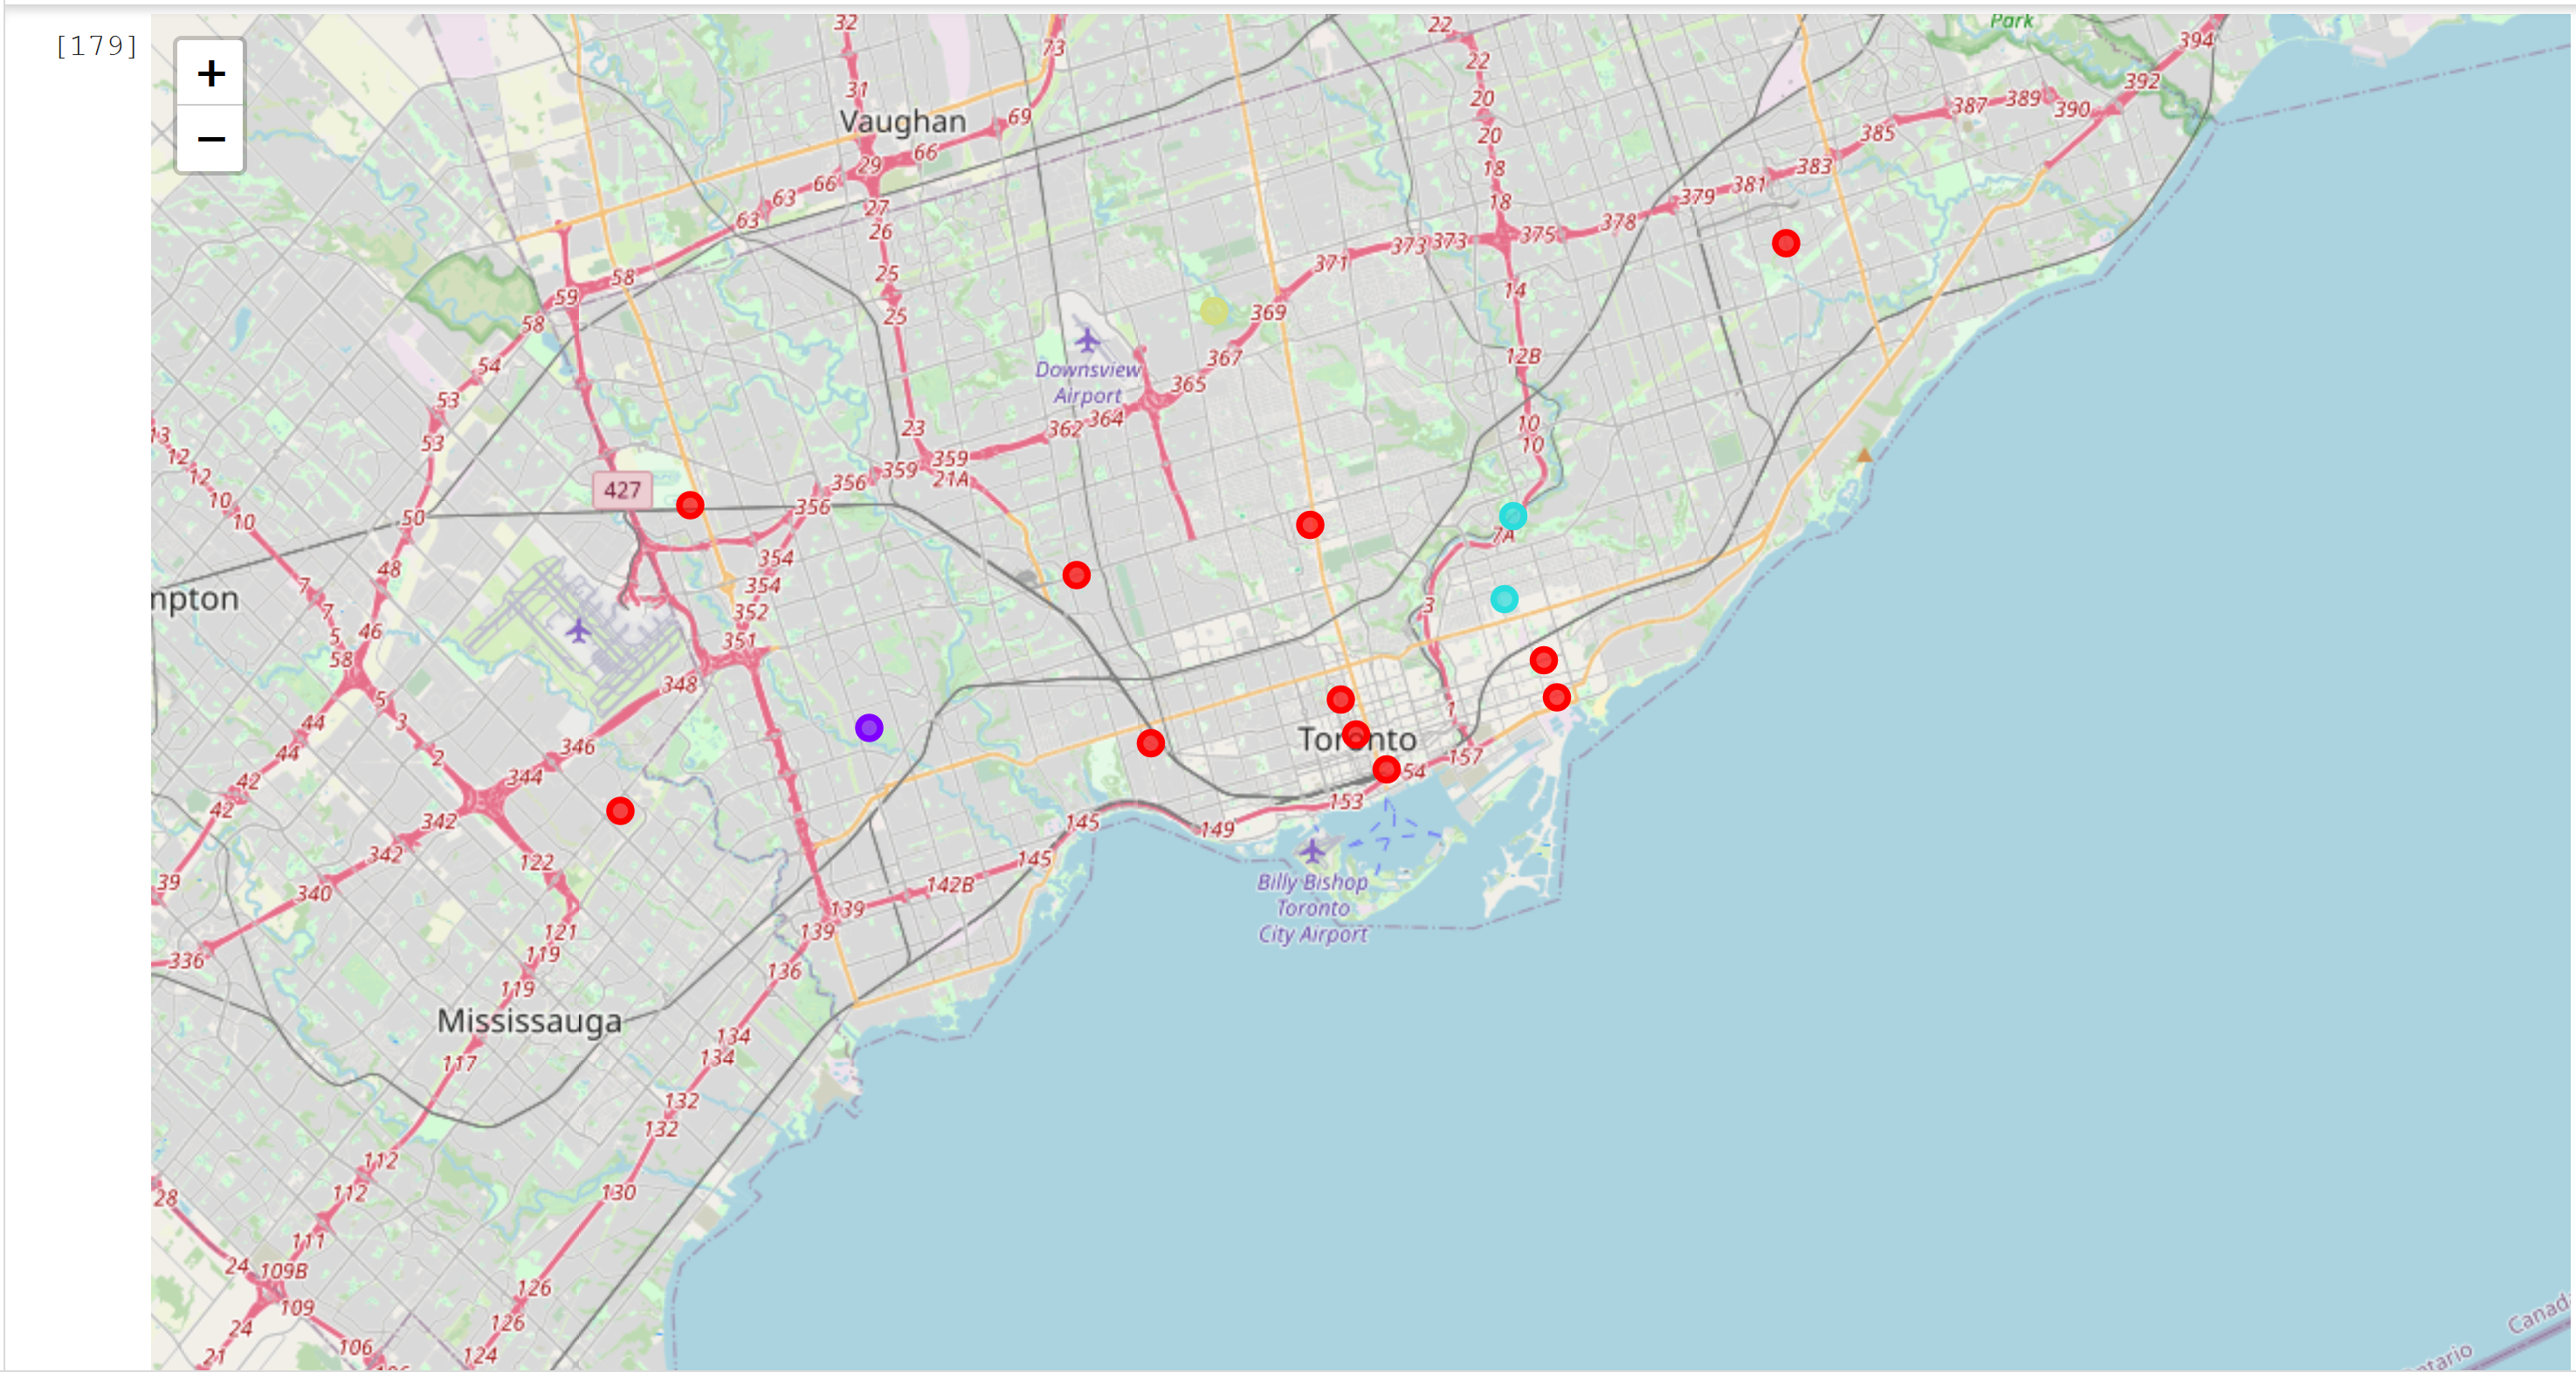